# Report: Gender Inequality: Relationship between Graduation Field and Wage Gap

## Content Overview

1. Introduction
2. Methods
    - Data Sources Description
    - Data Transformation
    - Installation of Dependencies
    - Data Loading
3. Results
4. Conclusion

## 1. Introduction

Ever since women joined the work forces, gender inequality in terms of wage gap has long been a phenomenon even in most developed economies. In the old days, due to low literacy rate and physical limitation, participation in less job roles might contribution greatly to inequality in working environment. While technology evolves and social norm changes, women are given more chances into different fields. Could this actually close the gender wage gap? To investigate the relationship between graduation field and wage gap, the question of this project is defined as followed:

- Could the graduation fields play a role in closing the gender wage gap?


## 2. Methods

### Data Sources Description

The following open datasets are used in the project:

1. OECD: Gender Wage Gap
    - Metadata : https://data.oecd.org/earnwage/gender-wage-gap.htm
    - Dataset URL : https://stats.oecd.org/sdmx-json/data/DP_LIVE/.WAGEGAP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en
    - Description: The dataset contains information of wage gap between female and male in each country per year. The great the number, the bigger the wage gap. Although the dataset included Self-employment, we focus only on "Employee".
    - Data Cleaning:
        - Load CSV
        - Filter "EMPLOYEE" in "SUBJECT"
        - Drop meaningless columns
        - Exclude "OECD" & "EU27" in dataset
        - Rename columns

2. World Bank: Gender Data Portal
    - Metadata: https://genderdata.worldbank.org/indicators/se-ter-grad-fe-zs
    - Dataset URL : https://databank.worldbank.org/data/download/Gender_Stats_CSV.zip
    - Description: The dataset contains female share in different graduation fields in different countries per year.
    - Data Cleaning:
        - Unpack zip file and load CSV
        - Exclude empty rows
        - Unpivot the table into "Graduation Field", "Year", "Female Share"
        - Drop meaningless columns
        - Exclude "other fields than Science, Technology, Engineering and Mathematics" & "unknown or unspecified" in dataset
        - Select countries which also available in OECD Gender Wage Gap dataset


### Data Transformation

Even though the basic data transformation was performed when the data pipeline is built, numerous challenges were encountered during data exploration. The major problem is the missing data. This section aims to explain the data selection and transformation in details.

__Step 1: Data Selection - Wage Gap Dataset__

1. Since there are still missing data in 2022, to avoid bias the selection of data will be limited to 20years until 2021, ie. 2001-2021.
2. Due to incomplete data for some countries, if there are more than 3 years of missing data, the country will be dropped.

_Result: After selection, only 18 countries in Wage Gap Dataset are selected._



__Step 2: Data Selection - Graduation Field Dataset__

1. First we select only countries with valid wage gap data. (18 countries)
2. Select data within 20 years, ie. 2001-2021. Unfortunately, most of the data is updated until 2017.
3. Missing value is checked. In some countries only few years of data are available. Therefore, we consider only countries with more than 5 year data to be considered. At the same time, both datasets are further restricted to number of countries.

_Result: Only 14 countries in both datasets are examined._



__Step 3: Extract Transformation to Facilitate Visualization__

1. Since the hypothesis is to prove that wage gap may be closed (value going down) when female share of certain graduation fields increase (value going up), it is difficult to compare the trends if they are going different direction. Therefore, "Non-Female Share" is added by calculating : 100 - Female Share.
2. After few attempts to visualize all dimensions in chart, subplot per country is the most reasonable way to divide data and yield insights. However, there are still 1 wage gap curve and many more lines to present different graduation fields. Therefore, grouping the graduation field may be considered to reduce visual noises. The grouping method is explained as below:
    - The first 5 years of the data of all countries is chosen, disregard to the availability.
    - Calculate the average female share of the first 5 years data.
    - Divide the graduation fields into three groups of "Traditional Groups of Fields":
        - with Female Majority (ie. Female Share > 66%)
        - with Male Majority (ie. Female Share < 33%)
        - with No Significant Majority

_Result: 2 Columns are added: "Non-Female Share" & "Traditional Groups of Fields"_

### Installation of Dependencies


In [2]:
%pip install pandas
%pip install seaborn
%pip install matplotlib
%pip install SQLAlchemy==1.4.46
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.



### Data Loading

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import warnings

pd.set_option('display.max_columns', 10)
db_path = '../data/project.sqlite'
engine = create_engine(f'sqlite:///{db_path}')

wage_gap_df = pd.read_sql('SELECT * FROM selected_wage_gap', con=engine)
graduate_df = pd.read_sql('SELECT * FROM selected_graduate_field', con=engine)

pd.set_option('display.max_columns', 30)
warnings.filterwarnings("ignore")

__Let's get basic impression of the dataset.__

Here's number of countries to be examined:

In [4]:
len(wage_gap_df["LOCATION"].unique())

14

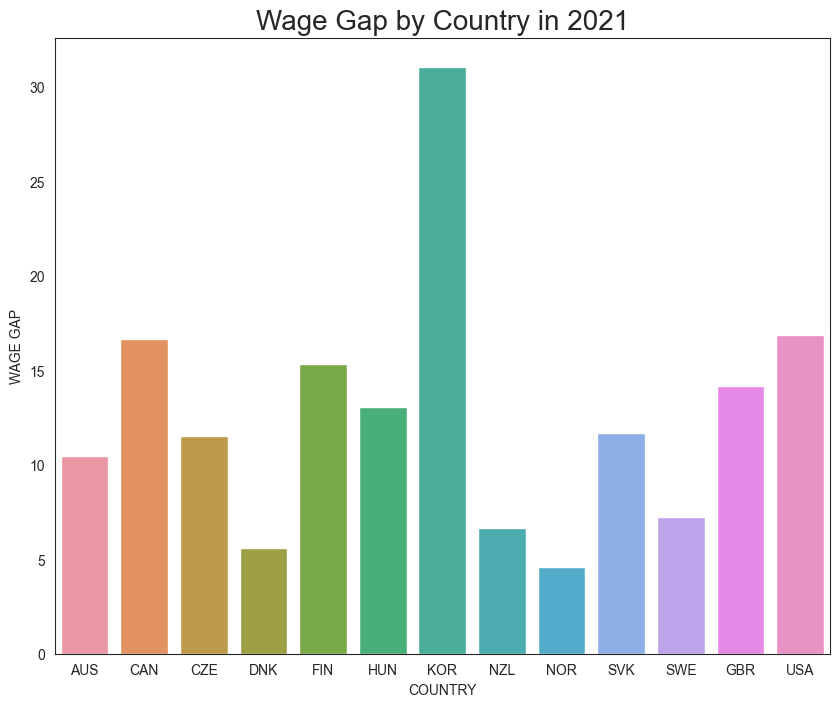

In [5]:
wage_gap_2021 = wage_gap_df[wage_gap_df["TIME"] == 2021]

import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter

sns.set_style("white")
plt.figure(figsize=(10, 8))
sns.barplot(data=wage_gap_2021, x="LOCATION", y="WAGE GAP")

plt.title("Wage Gap by Country in 2021", fontsize=20)
plt.xlabel("COUNTRY")
plt.show()

There is still a great wage gap in South Korea in 2021. In countries like USA, Great Britian, Canada and Finland, the wage gap is also obvious.

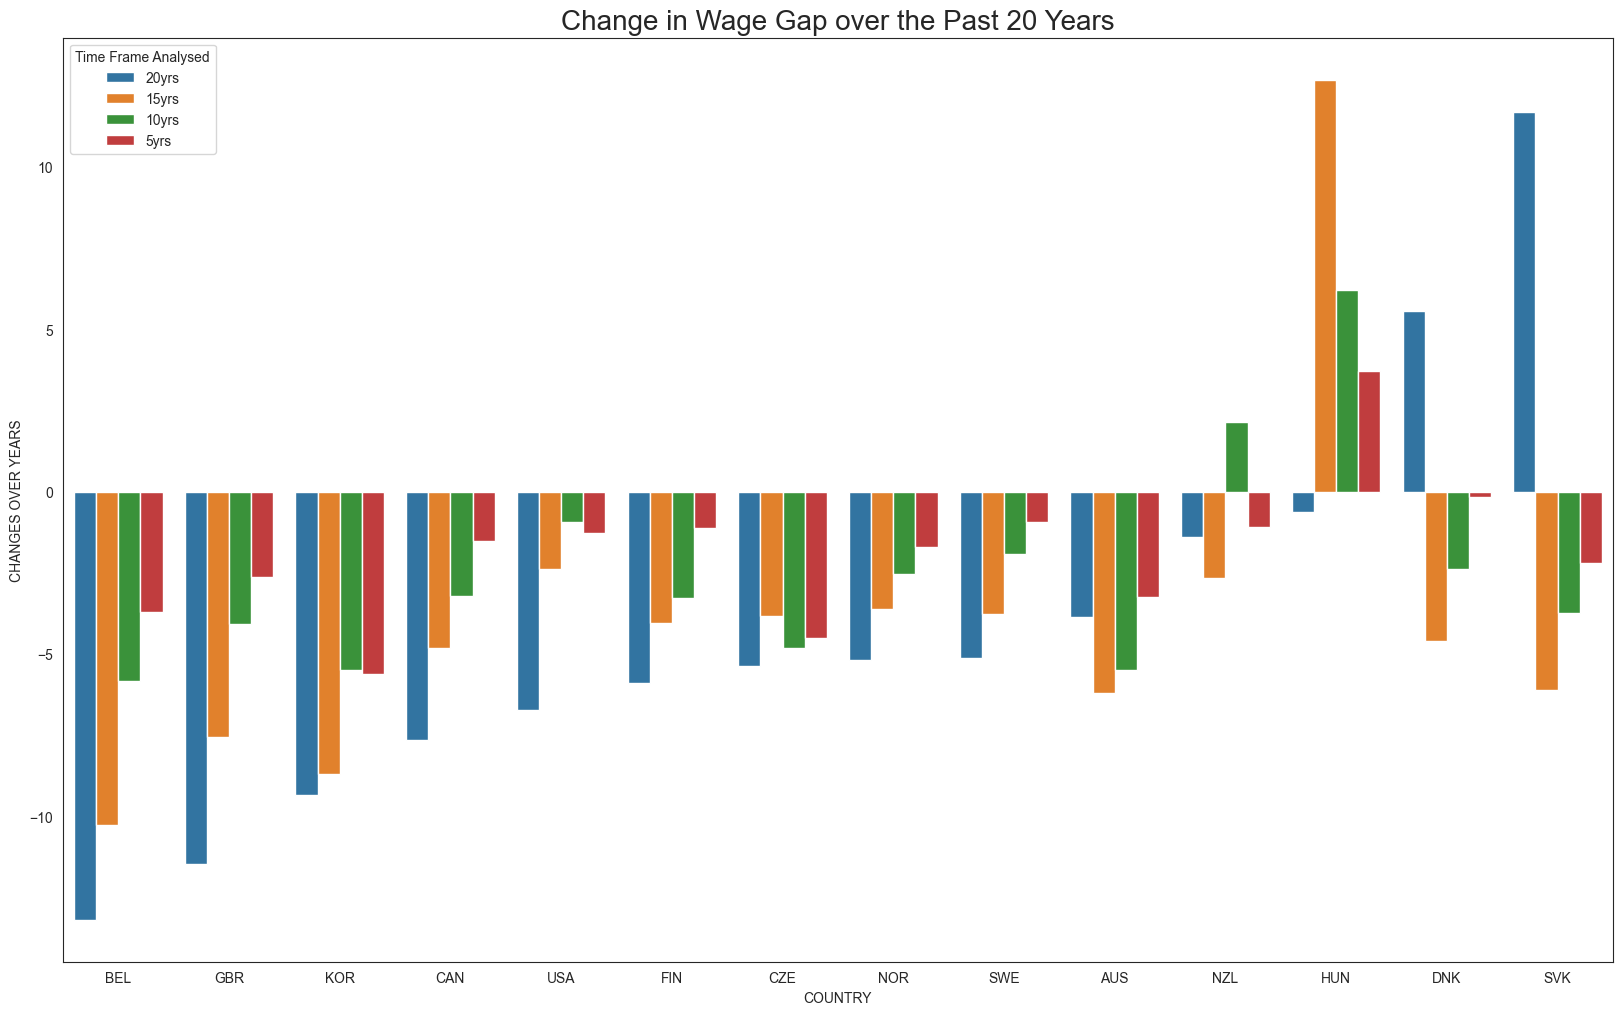

In [6]:
pivot = wage_gap_df.pivot_table(index="LOCATION", columns="TIME", values="WAGE GAP", fill_value=0)
latest_year = wage_gap_df["TIME"].max()
change_in_wage_gap = pd.DataFrame([])
change_in_wage_gap["20yrs"] = pivot[latest_year] - pivot[latest_year - 20]
change_in_wage_gap["15yrs"] = pivot[latest_year] - pivot[latest_year - 15]
change_in_wage_gap["10yrs"] = pivot[latest_year] - pivot[latest_year - 10]
change_in_wage_gap["5yrs"] = pivot[latest_year] - pivot[latest_year - 5]
change_in_wage_gap = change_in_wage_gap.reset_index()
melted_change_in_wage_gap = pd.melt(change_in_wage_gap, id_vars="LOCATION", value_vars=["20yrs","15yrs","10yrs","5yrs"], var_name='YEARS', value_name='CHANGES')

plt.figure(figsize=(20, 12))
sorted_df = melted_change_in_wage_gap[melted_change_in_wage_gap['YEARS'] == '20yrs'].sort_values('CHANGES')
sns.barplot(data=melted_change_in_wage_gap, x="LOCATION", y="CHANGES", hue="YEARS", order=sorted_df["LOCATION"])

plt.title("Change in Wage Gap over the Past 20 Years", fontsize=20)
plt.xlabel("COUNTRY")
plt.ylabel("CHANGES OVER YEARS")
plt.legend(title="Time Frame Analysed")
plt.show()

However, if we observe the changes over the past two decades, GBR, KOR, CAN, USA and FIN showed improvement. Belgium is the leading country to close the wage gap.

Next we would like to see the changes in Female Share in Graduation Field over the years.

<Figure size 2000x2000 with 0 Axes>

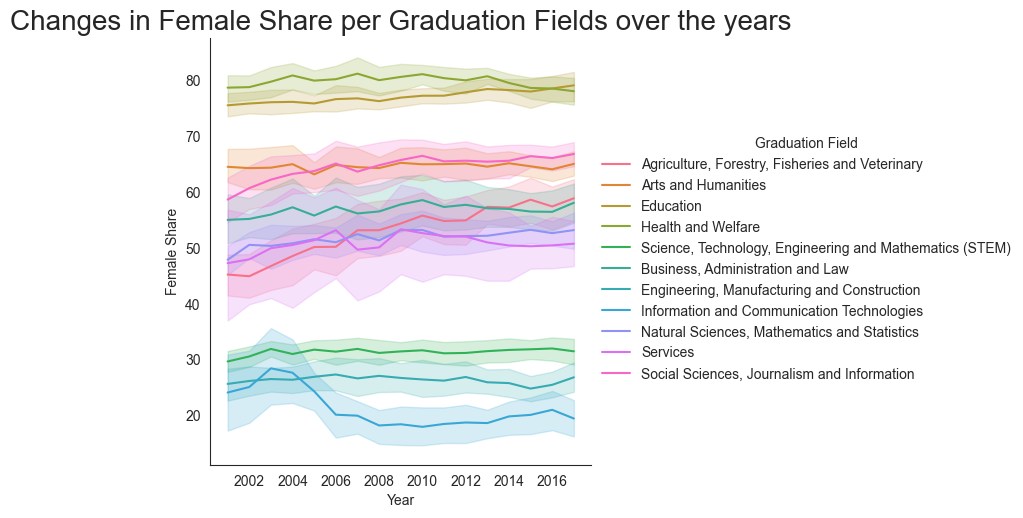

In [16]:

plt.figure(figsize=(20, 20))
sns.relplot(data=graduate_df, x="Year", y="Female Share", kind="line", hue="Graduation Field", markers=True, dashes=False)

plt.title("Changes in Female Share per Graduation Fields over the years", fontsize=20)
plt.show()

## 3. Results

To answer the question: "Could the graduation fields play a role in closing the gender wage gap?"

We first take a closer look on Belgium's case, as the changes in gender wage gap is the most significant:

In [8]:
bel_wage_gap = wage_gap_df[wage_gap_df["LOCATION"] == "BEL"]
bel_graduate = graduate_df[graduate_df["Country Code"] == "BEL"]

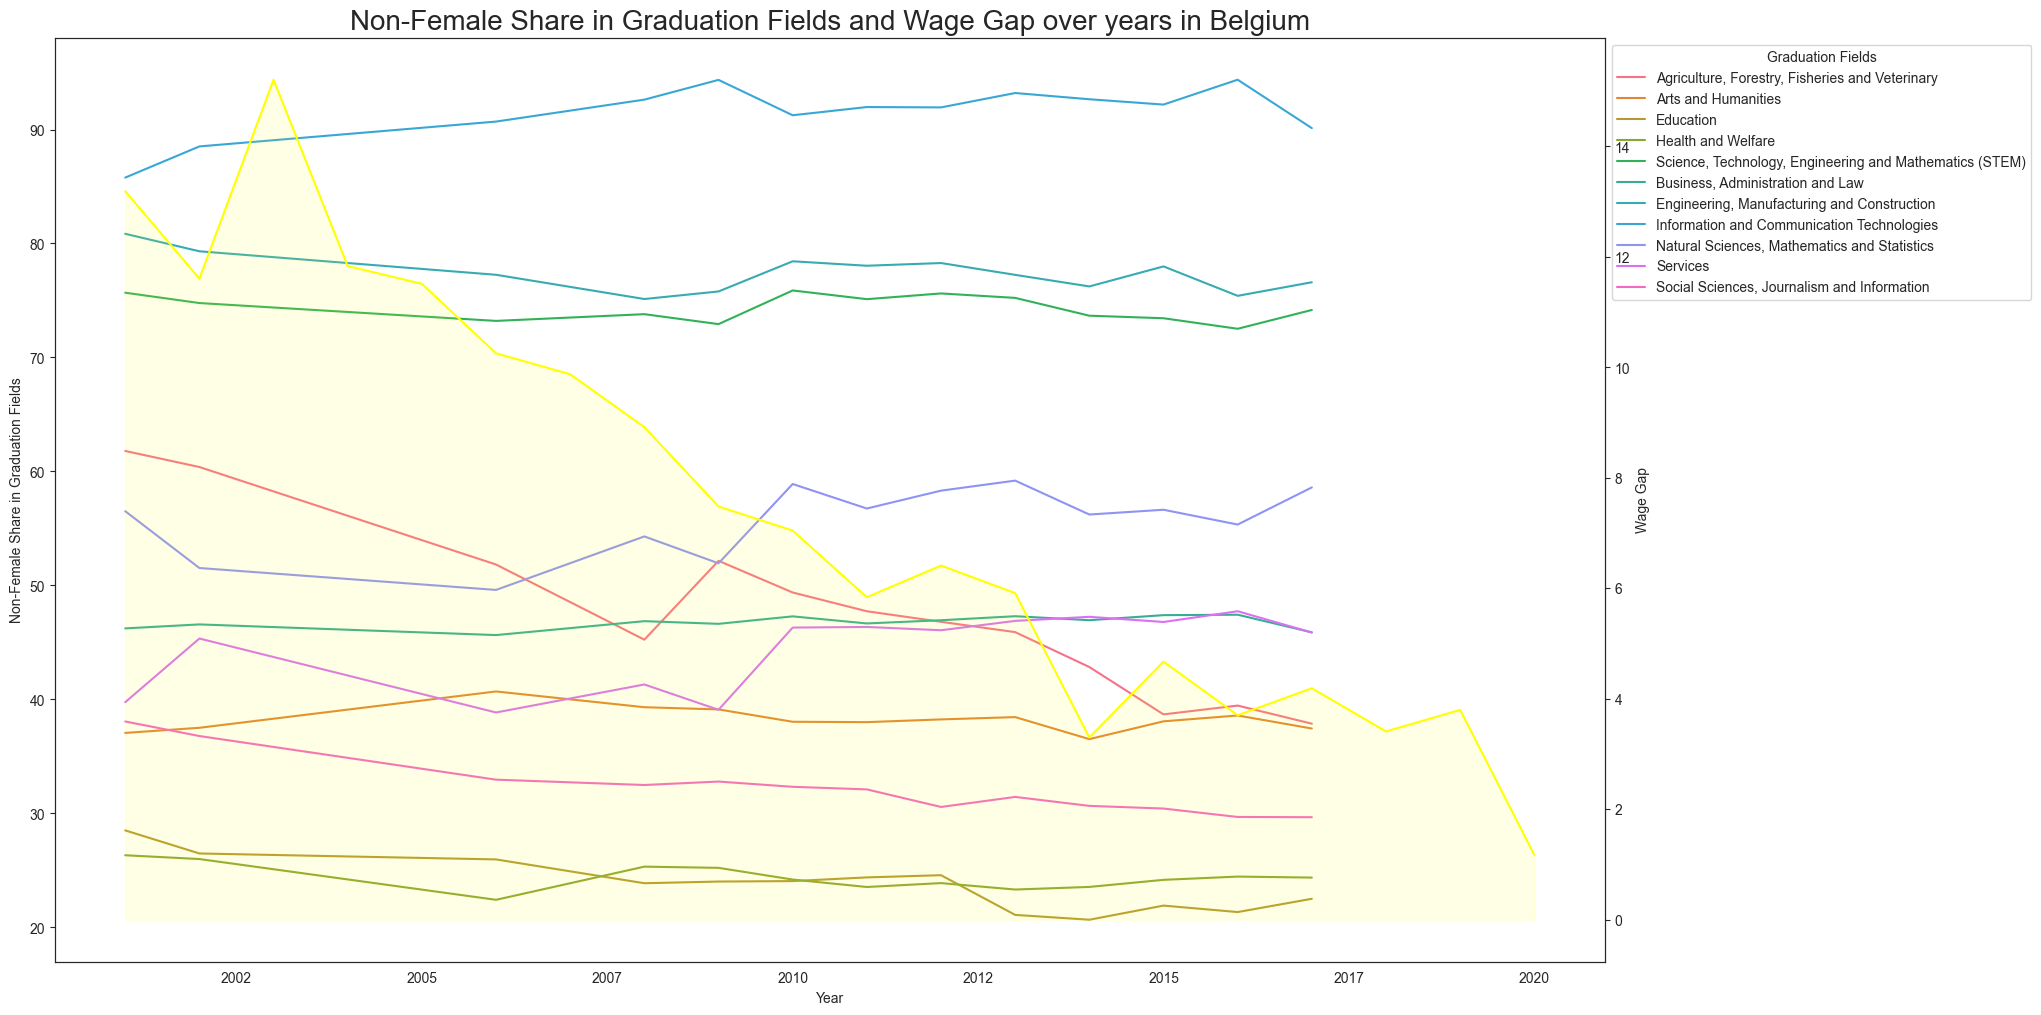

In [9]:
fig, ax1 = plt.subplots(figsize=(20, 12))

sns.lineplot(data=bel_graduate, x="Year", y="Non-Female Share", hue="Graduation Field", ax=ax1)
ax2 = ax1.twinx()
area_plot = sns.lineplot(data=bel_wage_gap, x="TIME", y="WAGE GAP", color='yellow', ax=ax2)
area_plot.fill_between(data=bel_wage_gap, x="TIME", y1="WAGE GAP", alpha=0.1, color='yellow')

ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

ax1.set_ylabel('Non-Female Share in Graduation Fields')
ax2.set_ylabel('Wage Gap')

plt.title('Non-Female Share in Graduation Fields and Wage Gap over years in Belgium', fontsize=20)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right', title="Graduation Fields", fontsize='large')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

plt.show()

As discussed in Data Preparation part, the large number of graduation field causes visual noises.
An additional group is therefore introduced to see if it is advantageous to show the trend.
To recall, the new group is defined as followed:
>    - The first 5 years of the data of all countries is chosen, disregard to the availability.
>    - Calculate the average female share of the first 5 years data.
>    - Divide the graduation fields into three groups of "Traditional Groups of Fields":
>        - with Female Majority (ie. Female Share > 66%)
>        - with Male Majority (ie. Female Share < 33%)
>        - with No Significant Majority
>        -
Here's the detailed grouping:

In [10]:
trad_group = graduate_df.groupby(["Traditional Groups of Fields","Graduation Field"]).agg({"Graduation Field":'nunique'})
trad_group

Graduation Field
Traditional Groups of Fields Graduation Field                                                    
with Female Majority         Education                                                          1
                             Health and Welfare                                                 1
                             Social Sciences, Journalism and Information                        1
with Male Majority           Engineering, Manufacturing and Construction                        1
                             Information and Communication Technologies                         1
                             Science, Technology, Engineering and Mathematic...                 1
with No Significant Majority Agriculture, Forestry, Fisheries and Veterinary                    1
                             Arts and Humanities                                                1
                             Business, Administration and Law                                   1
                             Natural Sciences, Mathematics and Statistics                       1
                             Services                                                           1

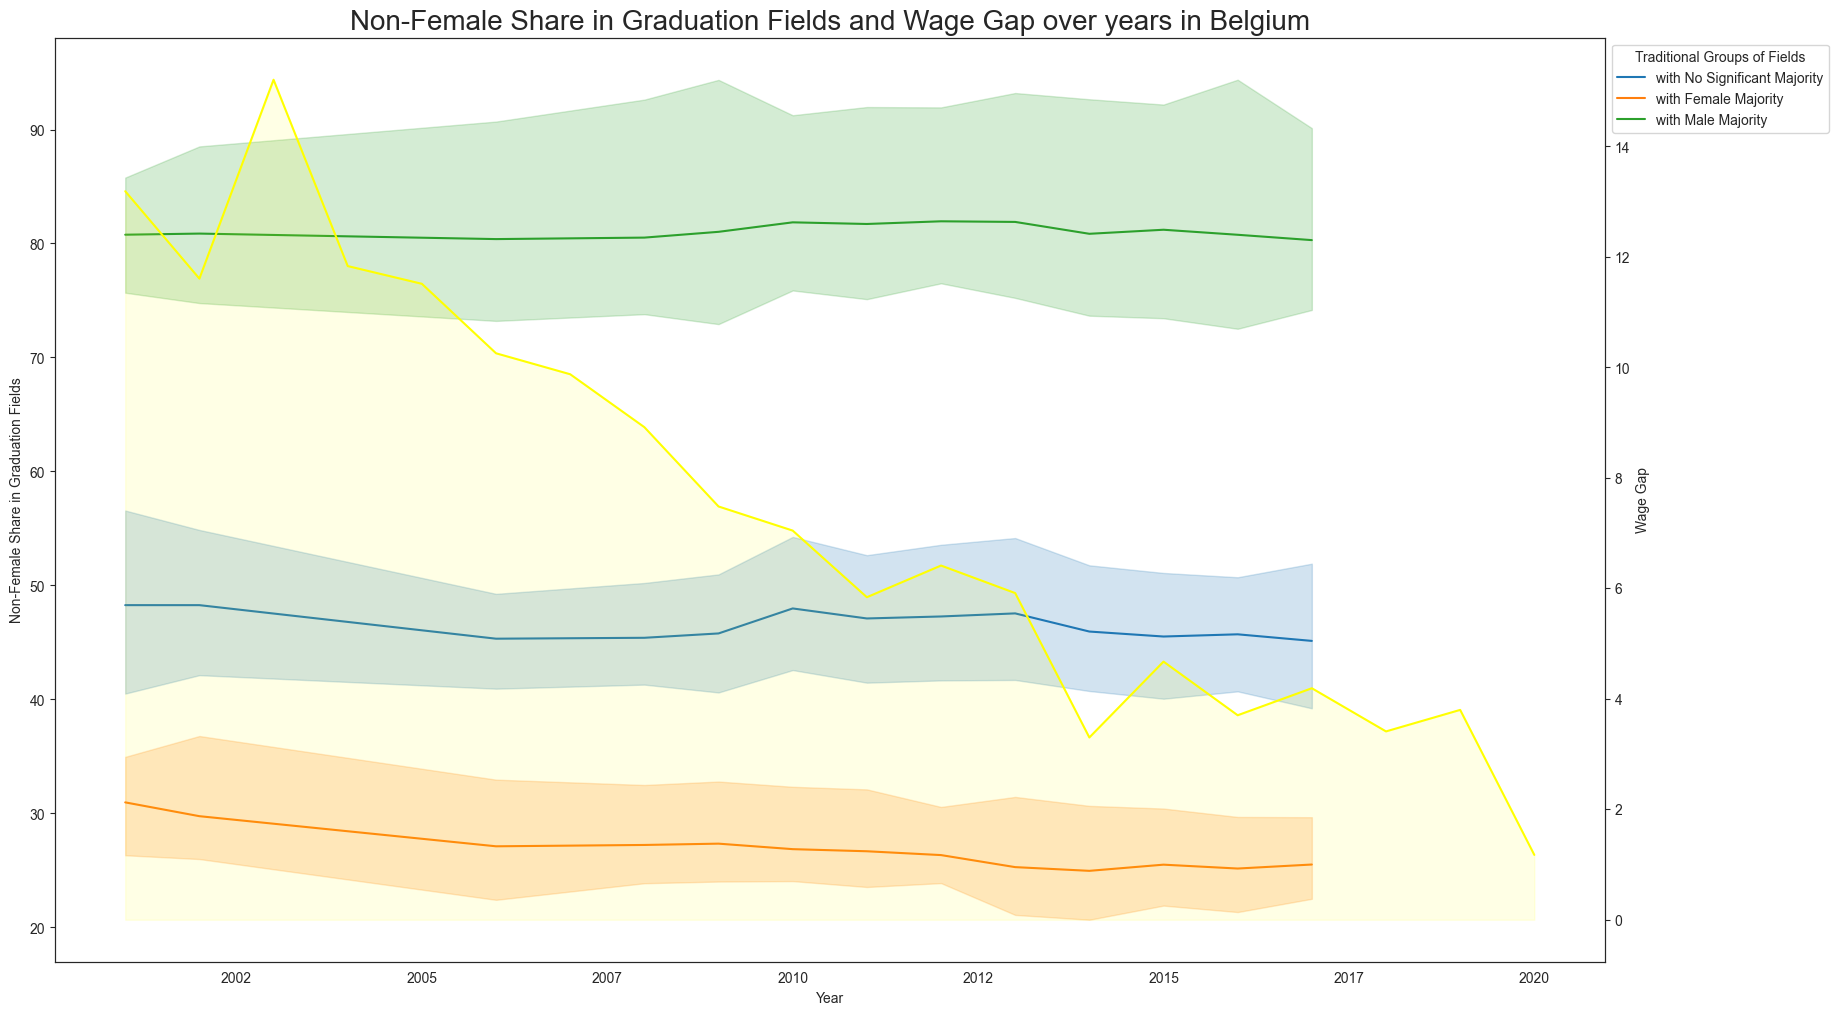

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 12))

sns.lineplot(data=bel_graduate, x="Year", y="Non-Female Share", hue="Traditional Groups of Fields", ax=ax1)
ax2 = ax1.twinx()
area_plot = sns.lineplot(data=bel_wage_gap, x="TIME", y="WAGE GAP", color='yellow', ax=ax2)
area_plot.fill_between(data=bel_wage_gap, x="TIME", y1="WAGE GAP", alpha=0.1, color='yellow')

ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

ax1.set_ylabel('Non-Female Share in Graduation Fields')
ax2.set_ylabel('Wage Gap')

plt.title('Non-Female Share in Graduation Fields and Wage Gap over years in Belgium', fontsize=20)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right', title="Traditional Groups of Fields", fontsize='large')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

plt.show()

All trends in 14 countries are as shown below:

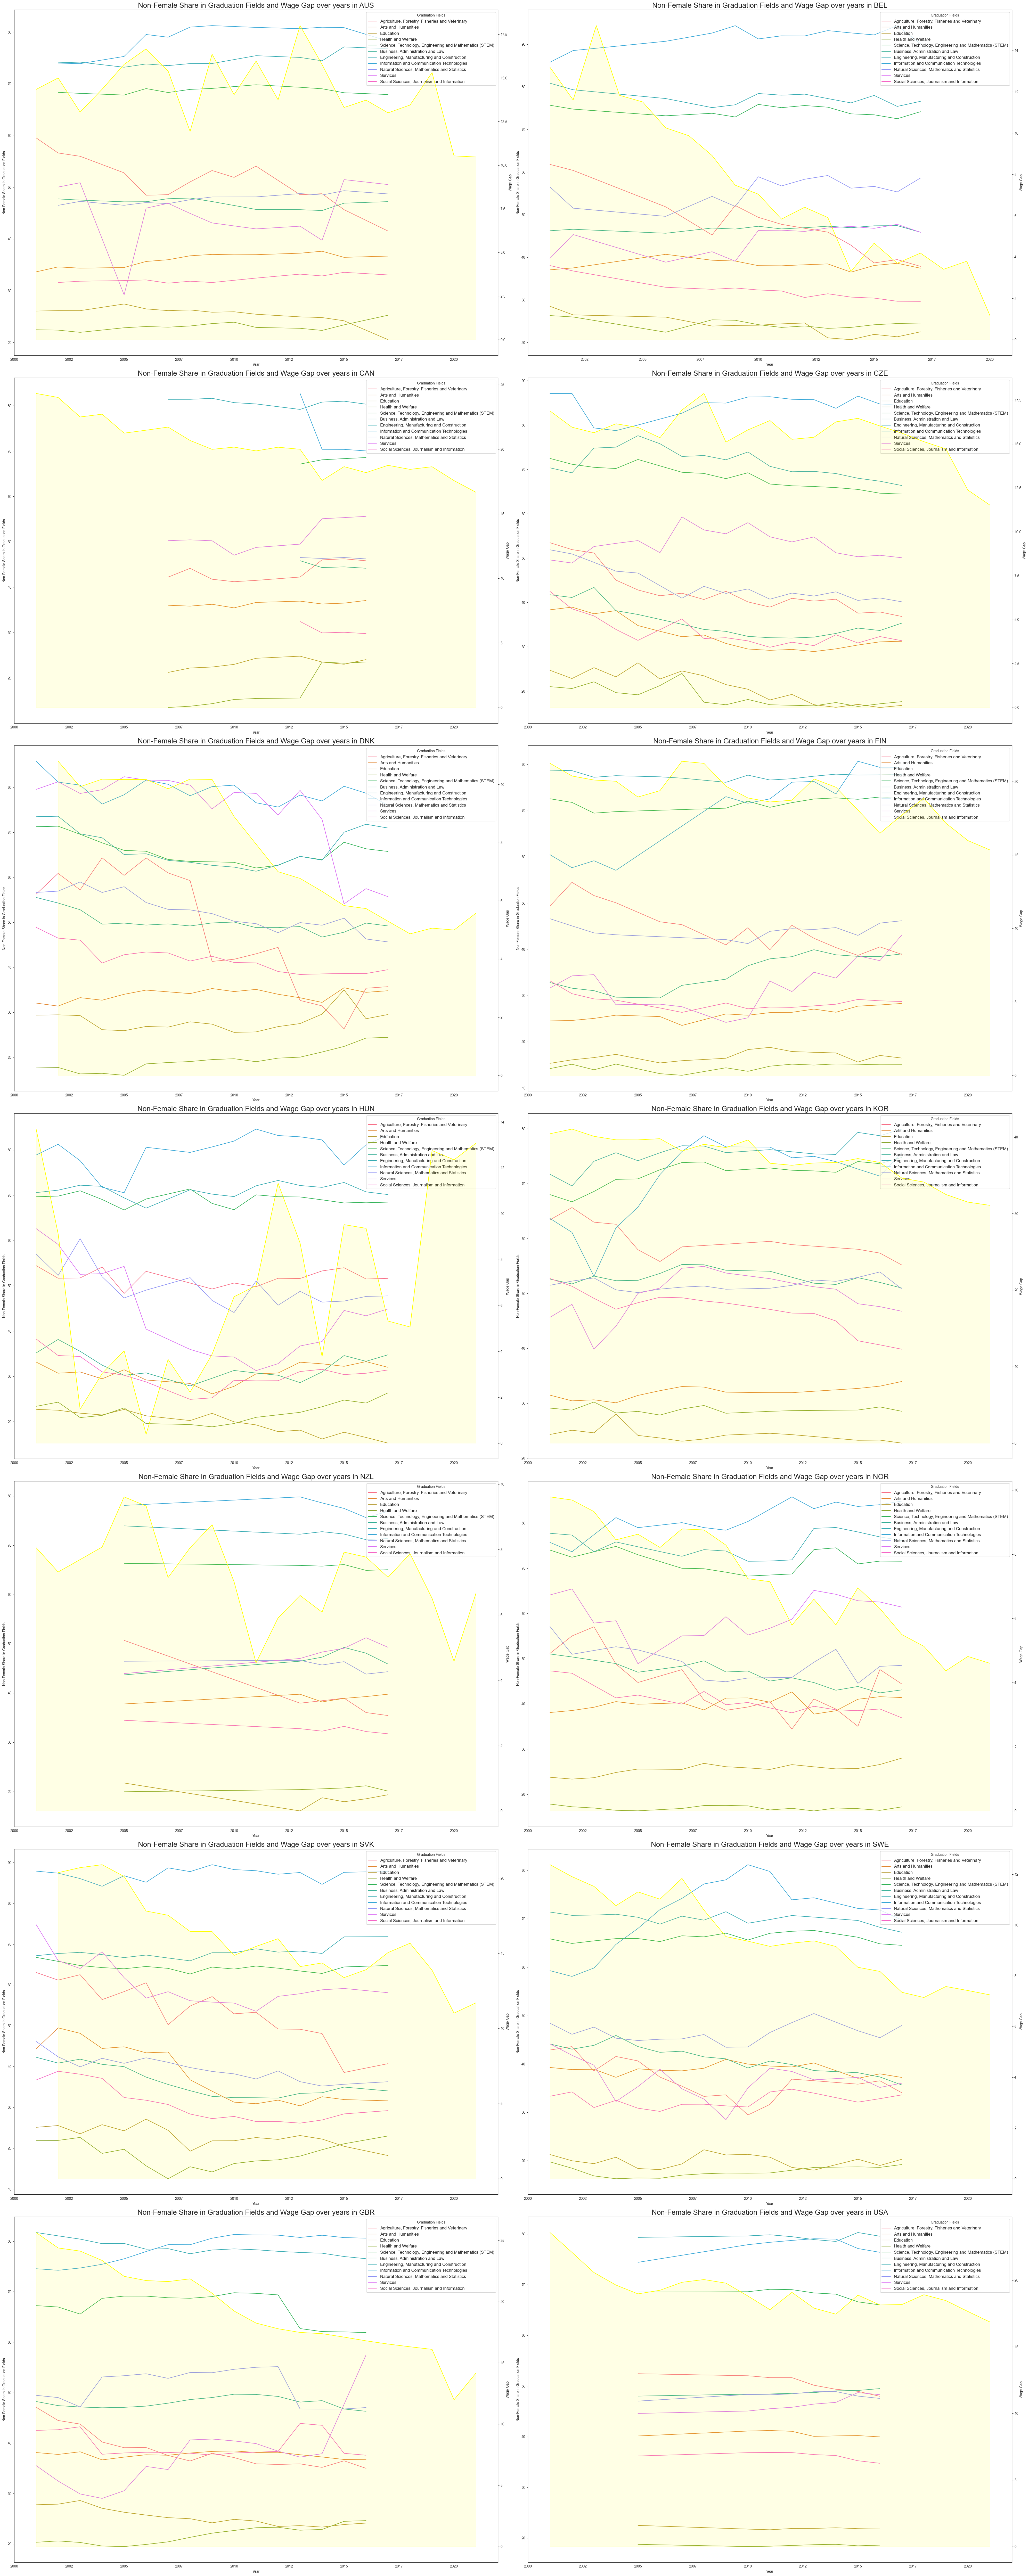

In [12]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(40, 100))
axes = axes.flatten()
country = iter(wage_gap_df["LOCATION"].unique())

for i, ax in enumerate(axes):
    country_i = next(country)

    ax.set_title(f'Non-Female Share in Graduation Fields and Wage Gap over years in {country_i}', fontsize=20)
    line_plot = sns.lineplot(data=graduate_df[graduate_df["Country Code"] == country_i], x="Year", y="Non-Female Share", hue="Graduation Field", ax=ax)
    ax2 = ax.twinx()
    area_plot = sns.lineplot(data=wage_gap_df[wage_gap_df["LOCATION"] == country_i], x="TIME", y="WAGE GAP", color='yellow', ax=ax2)
    area_plot.fill_between(data=wage_gap_df[wage_gap_df["LOCATION"] == country_i], x="TIME", y1="WAGE GAP", alpha=0.1, color='yellow')

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.set_ylabel('Non-Female Share in Graduation Fields')
    ax2.set_ylabel('Wage Gap')

    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper right', title="Graduation Fields", fontsize='large')

plt.tight_layout()
plt.show()

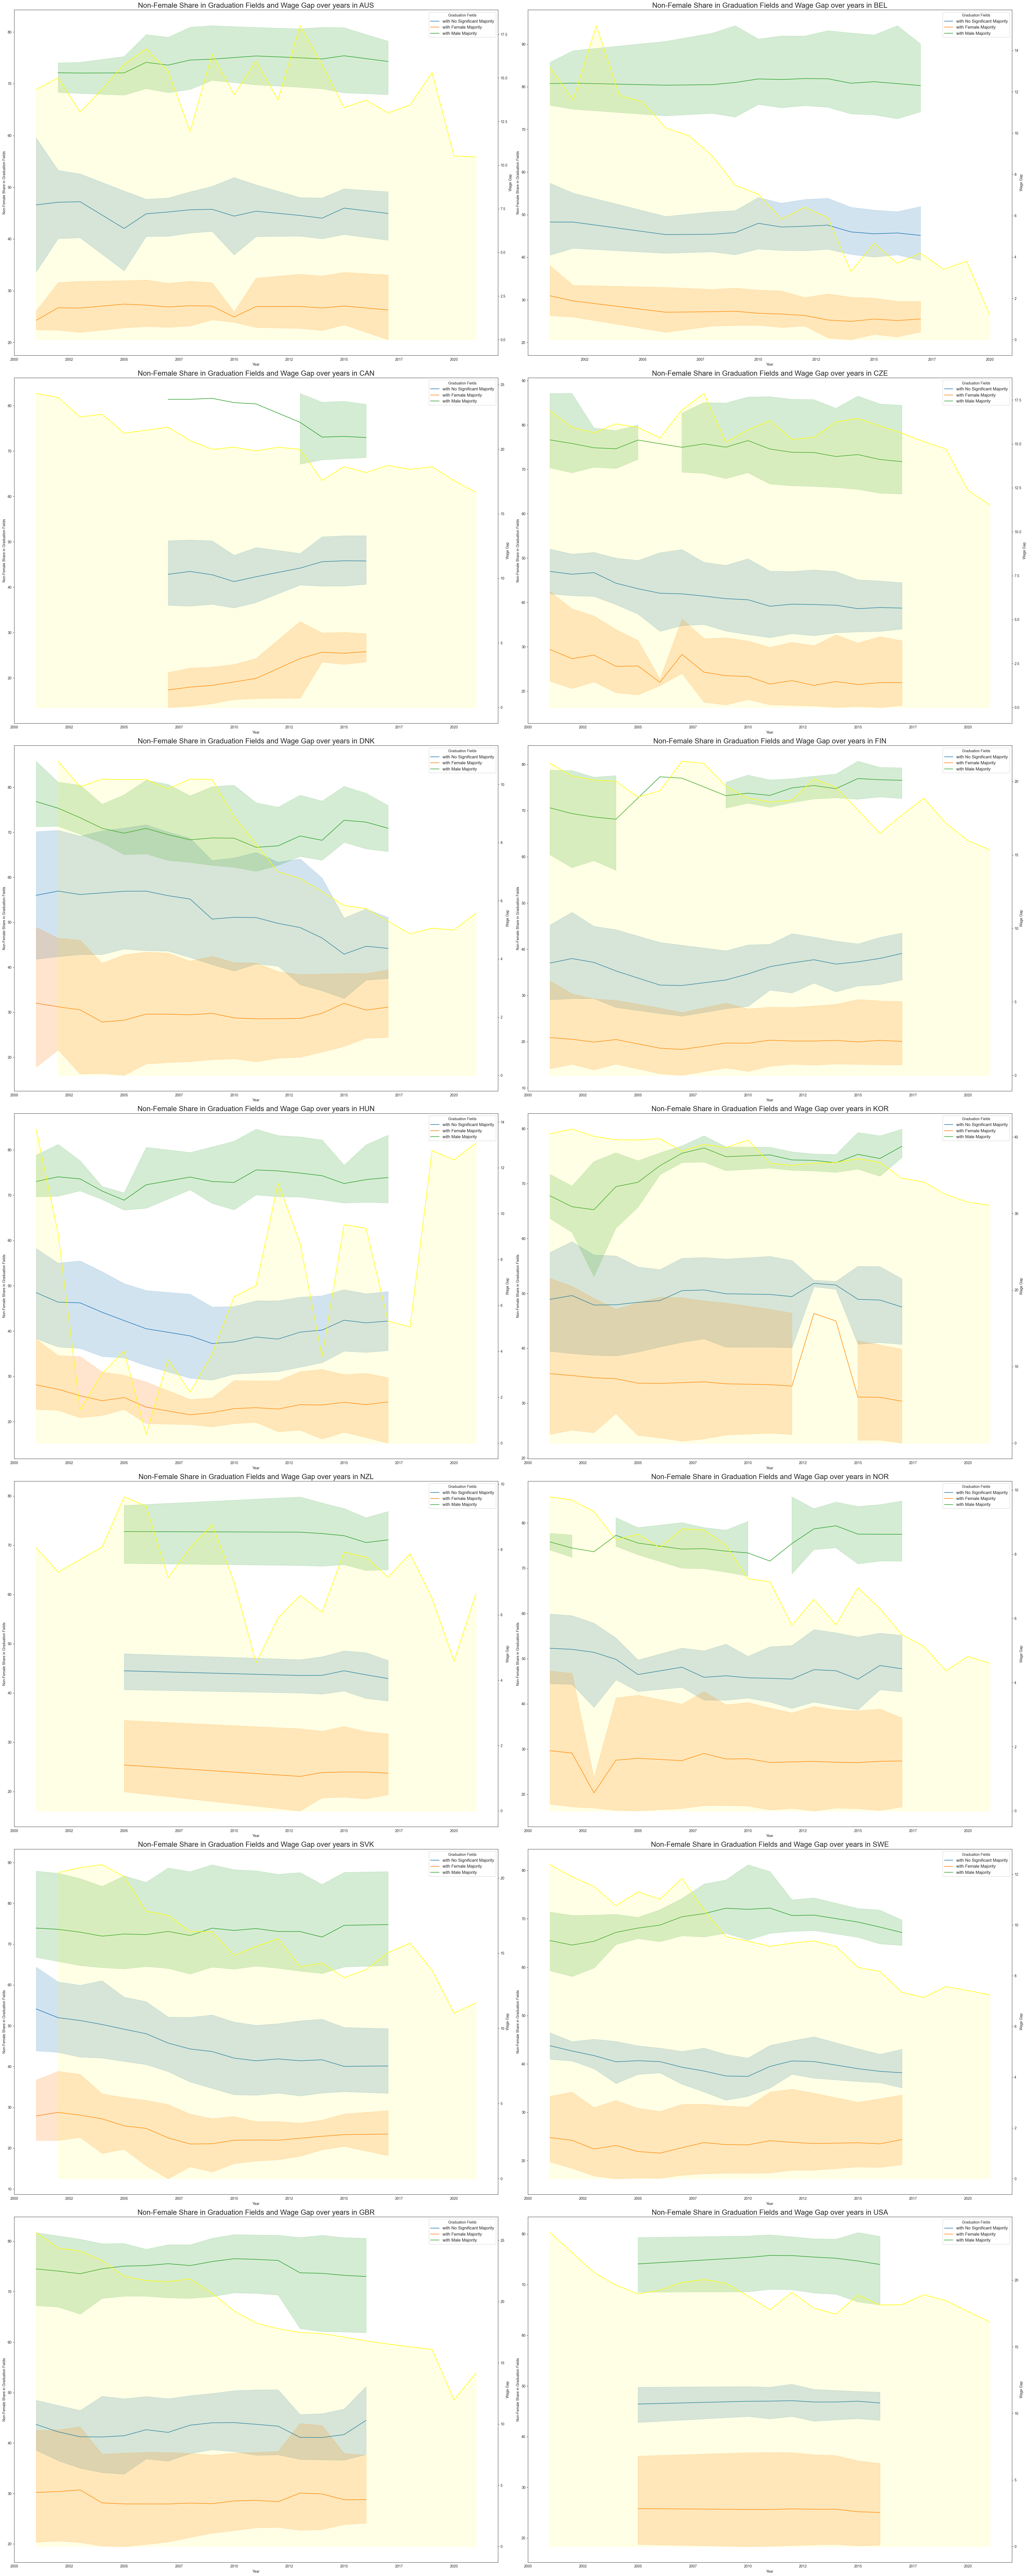

In [13]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(40, 100))
axes = axes.flatten()
country = iter(wage_gap_df["LOCATION"].unique())

for i, ax in enumerate(axes):
    country_i = next(country)

    ax.set_title(f'Non-Female Share in Graduation Fields and Wage Gap over years in {country_i}', fontsize=20)
    line_plot = sns.lineplot(data=graduate_df[graduate_df["Country Code"] == country_i], x="Year", y="Non-Female Share", hue="Traditional Groups of Fields", ax=ax)
    ax2 = ax.twinx()
    area_plot = sns.lineplot(data=wage_gap_df[wage_gap_df["LOCATION"] == country_i], x="TIME", y="WAGE GAP", color='yellow', ax=ax2)
    area_plot.fill_between(data=wage_gap_df[wage_gap_df["LOCATION"] == country_i], x="TIME", y1="WAGE GAP", alpha=0.1, color='yellow')

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.set_ylabel('Non-Female Share in Graduation Fields')
    ax2.set_ylabel('Wage Gap')

    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper right', title="Graduation Fields", fontsize='large')

plt.tight_layout()
plt.show()

The uneven area around the lines is due to missing data.
Again for easier references, the grouping of traditional groups of fields with gender share are as follows:

In [ ]:
trad_group

## 4. Conclusion

Sadly, with the limited amount of data, there are no significant evidence to show that graduation fields play a role in closing gender wage gap.
The female share in different graduation fields remind fluctuated over recent years.

One more thing to notice is that graduates may take some years until wage gap could actually happen, eg. at the time when some women decide to give birth and unavoidably take parental leave from the work. As the dataset from The World Bank is only available from 1998 to 2019 (or 2017 in most of the cases), there is no significant data to see the whole trend of female share changes over the decades.

Nevertheless, the author of this report is happy to see over the years the effort in closing gender wage gap is obvious in many countries. It may be worth to conduct further research in Belgium to understand how the wage gap could be closed significantly.